In [31]:
import numpy as np 
import pandas as pd 
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import seaborn as sns
import re
import os
import io
from scipy.stats import boxcox

In [32]:
df = pd.read_csv('Houston 2020.csv')
print("The shape of data is:",(df.shape))
display(df.head(3))

The shape of data is: (5385, 41)


,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,Street,...,Junction,Station,Railway,No_Exit,Crossing,Roundabout,Turning_Loop,Traffic_Calming,Traffic_Signal,Civil_Twilight
0,A-194,3,2020/11/4 16:18,2020/11/4 16:48,29.784912,-95.688347,0.000,Right and center lane blocked due to accident ...,NaN,Katy Tollway,...,False,False,False,False,False,False,False,False,False,Day
1,A-223,2,2020/12/19 6:35,2020/12/19 7:50,29.796590,-95.579627,0.169,Incident on SHERWOOD FOREST ST near HAZELHURST...,1688.0,Sherwood Forest St,...,False,False,False,False,False,False,False,False,False,Night
2,A-292,2,2020/12/6 23:00,2020/12/7 2:21,29.734968,-95.347444,0.017,Incident on GULF FWY SB near SCOTT ST Drive wi...,NaN,Gulf Fwy,...,False,False,True,False,True,False,False,False,True,Night


In [33]:
print("Wind Direction: ", df['Wind_Direction'].unique())

Wind Direction:  ['S' 'E' 'NNW' 'NNE' 'CALM' 'ESE' 'WNW' 'SE' 'SSE' 'W' 'WSW' 'ENE' 'SW'
 'NE' 'SSW' 'N' nan 'NW' 'VAR']


In [34]:
df = df.drop(['ID','Description','Distance(mi)', 'End_Time', 
              ], axis=1)

In [35]:
cat_names = ['Side', 'Country', 'Timezone', 'Amenity', 'Bump', 'Crossing', 
             'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 
             'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 
             'Civil_Twilight']
print("Unique count of categorical features:")
for i in cat_names:
  print(i,df[i].unique().size)

Unique count of categorical features:
Side 2
Country 1
Timezone 1
Amenity 2
Bump 2
Crossing 2
Give_Way 2
Junction 2
No_Exit 2
Railway 2
Roundabout 1
Station 2
Stop 2
Traffic_Calming 2
Traffic_Signal 2
Turning_Loop 1
Civil_Twilight 2


In [6]:
df = df.drop(['Country','Turning_Loop'], axis=1)

In [7]:
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['S' 'E' 'N' 'CALM' 'W' 'SE' 'SW' 'NE' nan 'NW' 'VAR']


In [8]:
# show distinctive weather conditions 
weather ='!'.join(df['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

Weather Conditions:  ['', 'Cloudy', 'Drizzle', 'Dust', 'Fair', 'Fog', 'Haze', 'Heavy Rain', 'Heavy T-Storm', 'Light Drizzle', 'Light Rain', 'Mist', 'Rain', 'Shallow Fog', 'T-Storm', 'Thunder', 'Thunder in the Vicinity', 'Widespread Dust', 'Windy']


In [9]:
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear', case=False, na = False), True, False)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), True, False)
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Rain|storm', case=False, na = False), True, False)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), True, False)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), True, False)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na = False), True, False)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog', case=False, na = False), True, False)

In [10]:
# Assign NA to created weather features where 'Weather_Condition' is null.
weather = ['Clear','Cloud','Rain','Heavy_Rain','Snow','Heavy_Snow','Fog']
for i in weather:
    df.loc[df['Weather_Condition'].isnull(),i] = df.loc[df['Weather_Condition'].isnull(),'Weather_Condition']
    df[i] = df[i].astype('bool')

df.loc[:,['Weather_Condition'] + weather]

df = df.drop(['Weather_Condition'], axis=1)

In [11]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Percent(%)']
missing['Missing_Percent(%)'] = missing['Missing_Percent(%)'].apply(lambda x: x / df.shape[0] * 100)
missing.loc[missing['Missing_Percent(%)']>0,:]

,Feature,Missing_Percent(%)
4,Number,48.207985
13,Temperature(F),0.501393
14,Wind_Chill(F),0.668524
15,Humidity(%),0.501393
16,Pressure(in),0.408542
17,Visibility(mi),0.445682
18,Wind_Direction,0.612813
19,Wind_Speed(mph),0.612813
20,Precipitation(in),1.504178


In [12]:
df = df.drop(['Number'], axis=1)

In [13]:
df['Precipitation_NA'] = 0
df.loc[df['Precipitation(in)'].isnull(),'Precipitation_NA'] = 1
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].median())
df.loc[:5,['Precipitation(in)','Precipitation_NA']]

,Precipitation(in),Precipitation_NA
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
5,0.0,0


In [14]:
df['Severity2'] = 0
df.loc[df['Severity'] == 2, 'Severity2'] = 1
df = df.drop(['Severity'], axis = 1)
df.Severity2.value_counts()

1    4481
0     904
Name: Severity2, dtype: int64

In [15]:
def resample(dat, col, n):
    return pd.concat([dat[dat[col]==1].sample(n, replace = True),
                   dat[dat[col]==0].sample(n)], axis=0)

In [16]:
df_bl = resample(df, 'Severity2', 900)
print('resampled data:', df_bl.Severity2.value_counts())

resampled data: 1    900
0    900
Name: Severity2, dtype: int64


In [17]:
df_bl = resample(df, 'Severity2', 900)

In [18]:
from collections import Counter
# create a list of top 40 most common words in street name
st_type =' '.join(df['Street'].unique().tolist()) # flat the array of street name
st_type = re.split(" |-", st_type) # split the long string by space and hyphen
st_type = [x[0] for x in Counter(st_type).most_common(40)] # select the 40 most common words
print('the 40 most common words')
print(*st_type, sep = ", ") 

the 40 most common words
, St, Dr, Rd, Ln, W, Blvd, S, N, E, Pkwy, Houston, Sam, Fwy, Ave, Park, Loop, Oak, Way, Tollway, I, Creek, TX, Lake, North, La, Post, Oaks, Ashford, San, Forest, York, Hardy, Tidwell, Greens, Gulf, Ridge, Gessner, Wayside, Glen


#### Street ####
There are more and more studies found that higher speed limits were associated with an increased likelihood of crashes and deaths. (https://www.cga.ct.gov/2013/rpt/2013-R-0074.htm) And speed limits are highly related to street type. Street type hence can be a good predictor of serious accidents. There is no feature about street type in the original dataset though, we can extract it from the street name.

The top 40 most common words in street names were selected. This list contains not only street types but also some common words widely used in street names.

Remove some irrelevant words and add spaces and hyphen back

In [19]:
# Remove some irrelevant words and add spaces and hyphen back
st_type= [' Rd', ' St', ' Dr', ' Ave', ' Blvd', ' Ln', ' Highway', ' Pkwy', ' Hwy', 
          ' Way', ' Ct', 'Pl', ' Road', 'US-', 'Creek', ' Cir',  'Route', 
          'I-', 'Trl', 'Pike', ' Fwy','Park','Loop','Tollway',]
print(*st_type, sep = ", ")  

 Rd,  St,  Dr,  Ave,  Blvd,  Ln,  Highway,  Pkwy,  Hwy,  Way,  Ct, Pl,  Road, US-, Creek,  Cir, Route, I-, Trl, Pike,  Fwy, Park, Loop, Tollway


Create a dummy variable for each word in the list and plot the correlation between these key words and severity.

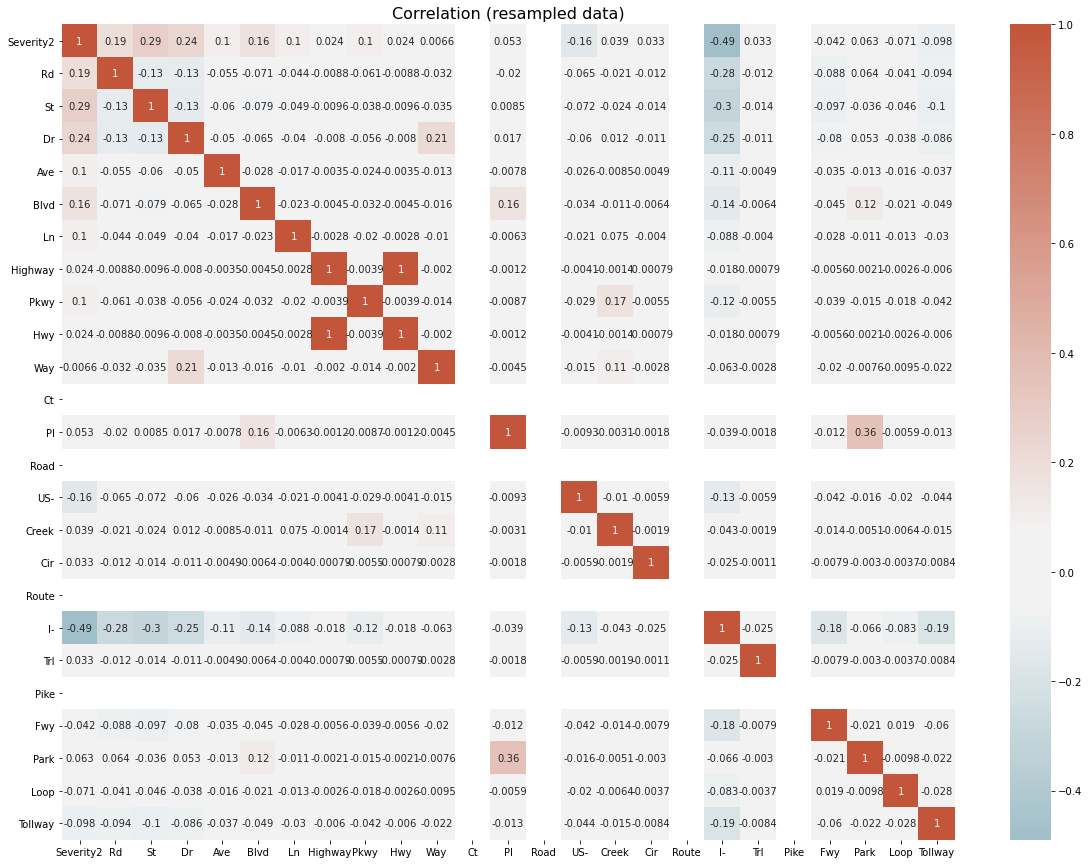

In [20]:
# for each word create a boolean column
for i in st_type:
  df[i.strip()] = np.where(df['Street'].str.contains(i, case=True, na = False), True, False)
df.loc[df['Road']==1,'Rd'] = True
df.loc[df['Highway']==1,'Hwy'] = True

# resample again
df_bl = resample(df, 'Severity2', 900)

# plot correlation
df_bl['Severity2'] = df_bl['Severity2'].astype(int)
street_corr  = df_bl.loc[:,['Severity2']+[x.strip() for x in st_type]].corr()
plt.figure(figsize=(20,15))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(street_corr, annot=True, cmap=cmap, center=0).set_title("Correlation (resampled data)", fontsize=16)
plt.show()

Interstate Highway turns out to be the most dangerous street. Other roads like basic road, street, drive, and avenue are relatively safe. Let's just keep these five features.

In [21]:
drop_list = street_corr.index[street_corr['Severity2'].abs()<0.1].to_list()
df = df.drop(drop_list, axis=1)

# resample again
df_bl = resample(df, 'Severity2', 900)

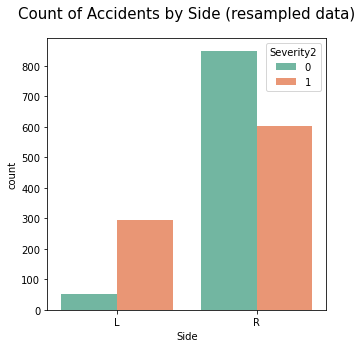

In [22]:
plt.figure(figsize=(5,5))
chart = sns.countplot(x='Side', hue='Severity2', data=df_bl ,palette="Set2")
plt.title("Count of Accidents by Side (resampled data)", size=15, y=1.05)
plt.show()

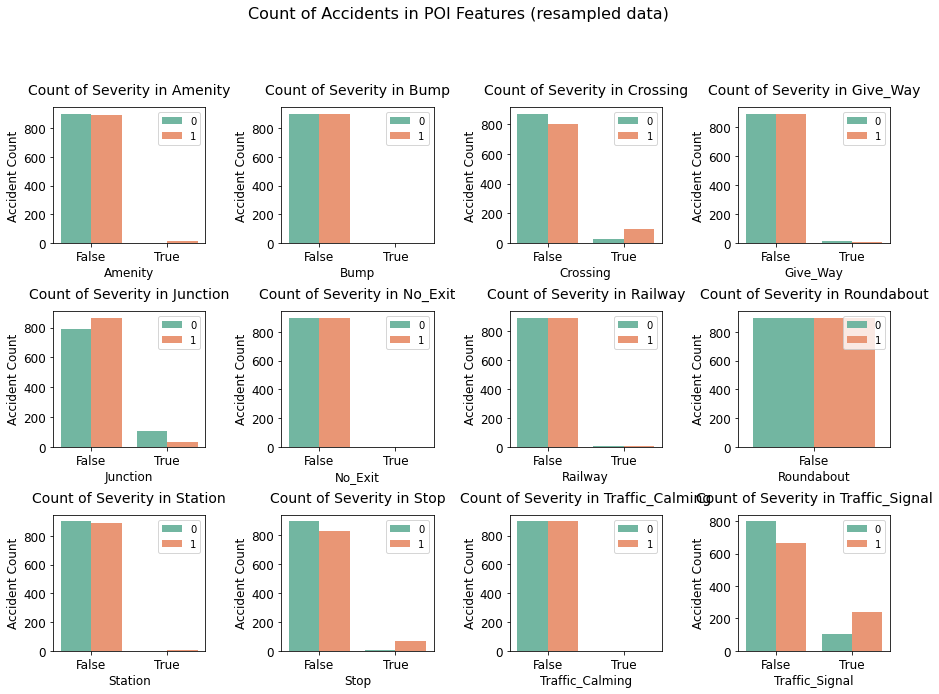

In [23]:
POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(15, 10))

plt.subplots_adjust(hspace=0.5,wspace = 0.5)
for i, feature in enumerate(POI_features, 1):    
    plt.subplot(3, 4, i)
    sns.countplot(x=feature, hue='Severity2', data=df_bl ,palette="Set2")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['0', '1'], loc='upper right', prop={'size': 10})
    plt.title('Count of Severity in {}'.format(feature), size=14, y=1.05)
fig.suptitle('Count of Accidents in POI Features (resampled data)',y=1.02, fontsize=16)
plt.show()

In [24]:
df= df.drop(['Bump','No_Exit','Roundabout','Traffic_Calming'], axis=1)

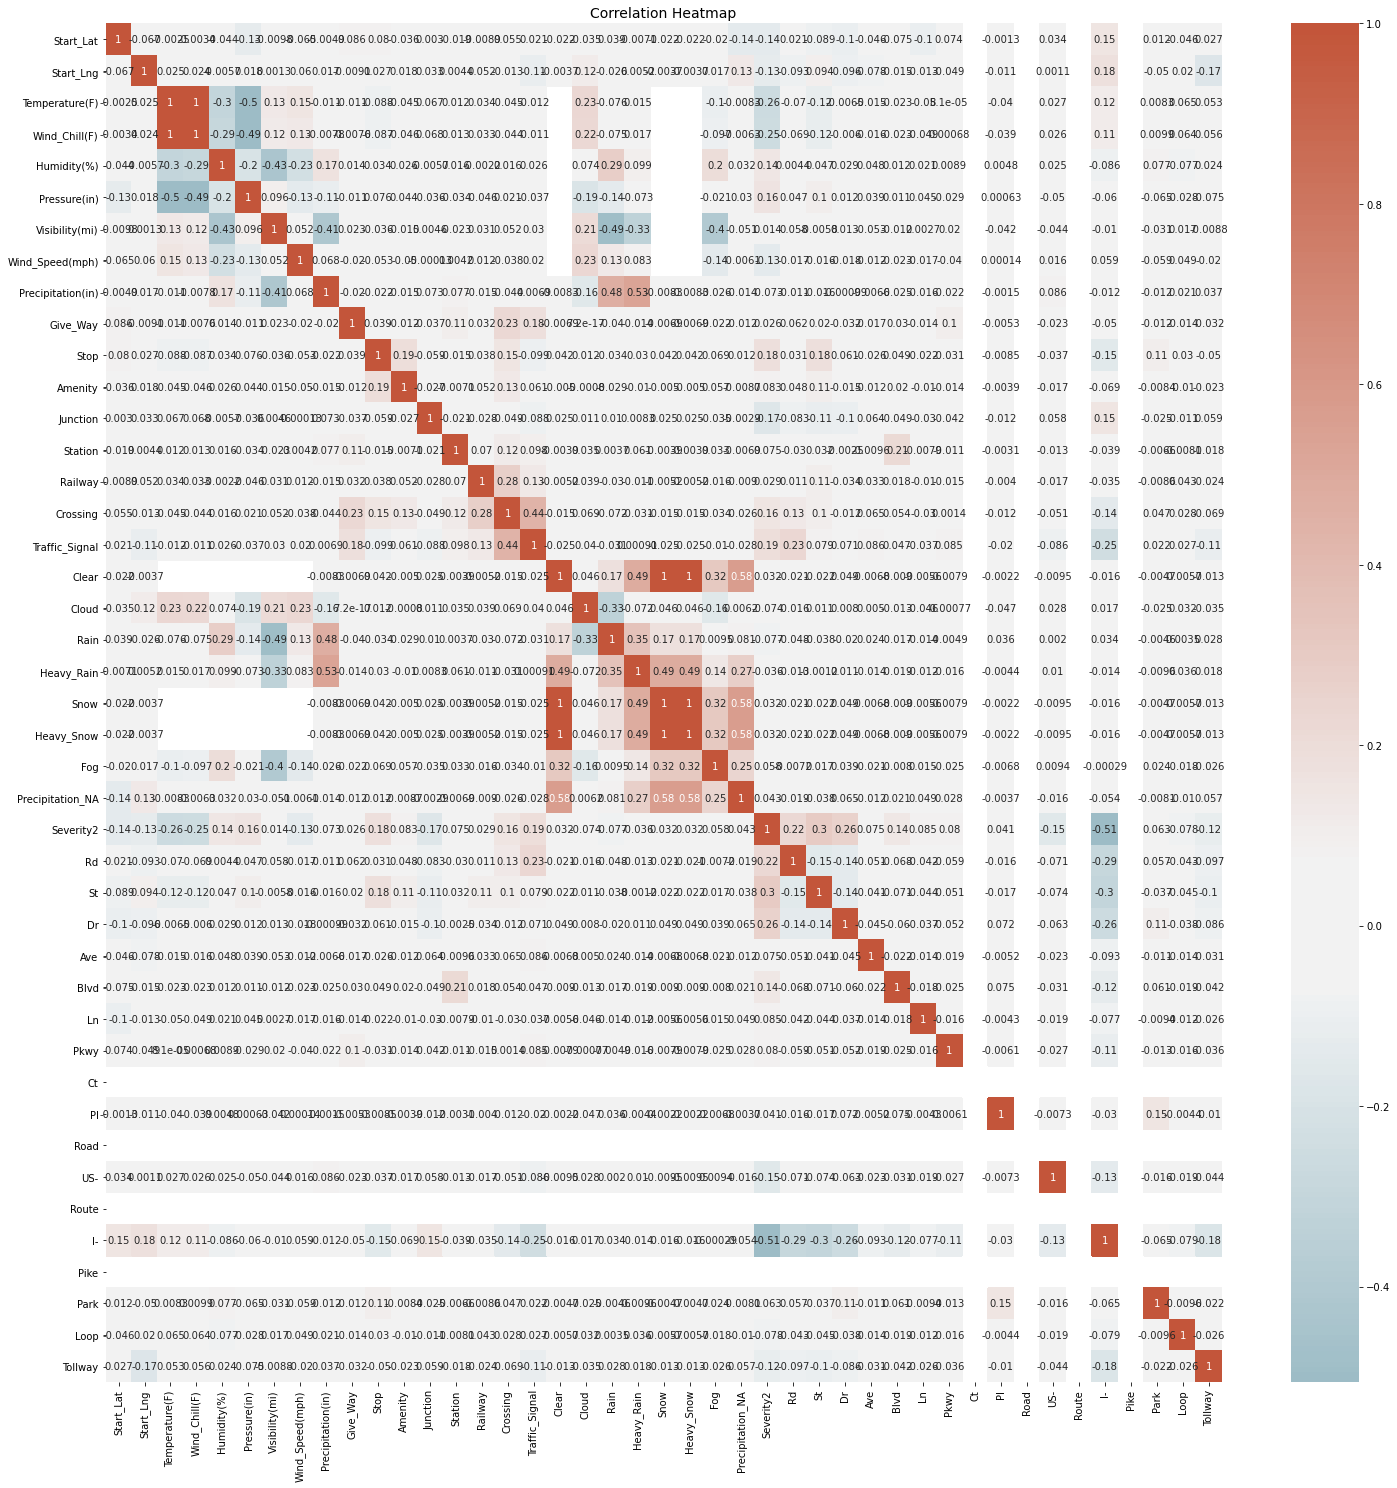

In [25]:
# resample again
df_bl = resample(df, 'Severity2', 900)

# plot correlation
df_bl['Severity2'] = df_bl['Severity2'].astype(int)
plt.figure(figsize=(25,25))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df_bl.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=14)
plt.show()

In [26]:
df = df.drop(['Temperature(F)', 'Wind_Chill(F)','Humidity(%)', 'Precipitation(in)', 'Precipitation_NA',
              'Clear','Cloud','Snow'], axis=1)

In [27]:
df = df.drop(['Pressure(in)', 'Visibility(mi)','Wind_Speed(mph)','Rain','Heavy_Rain','Heavy_Snow','Road','Route','Pike'], axis=1)

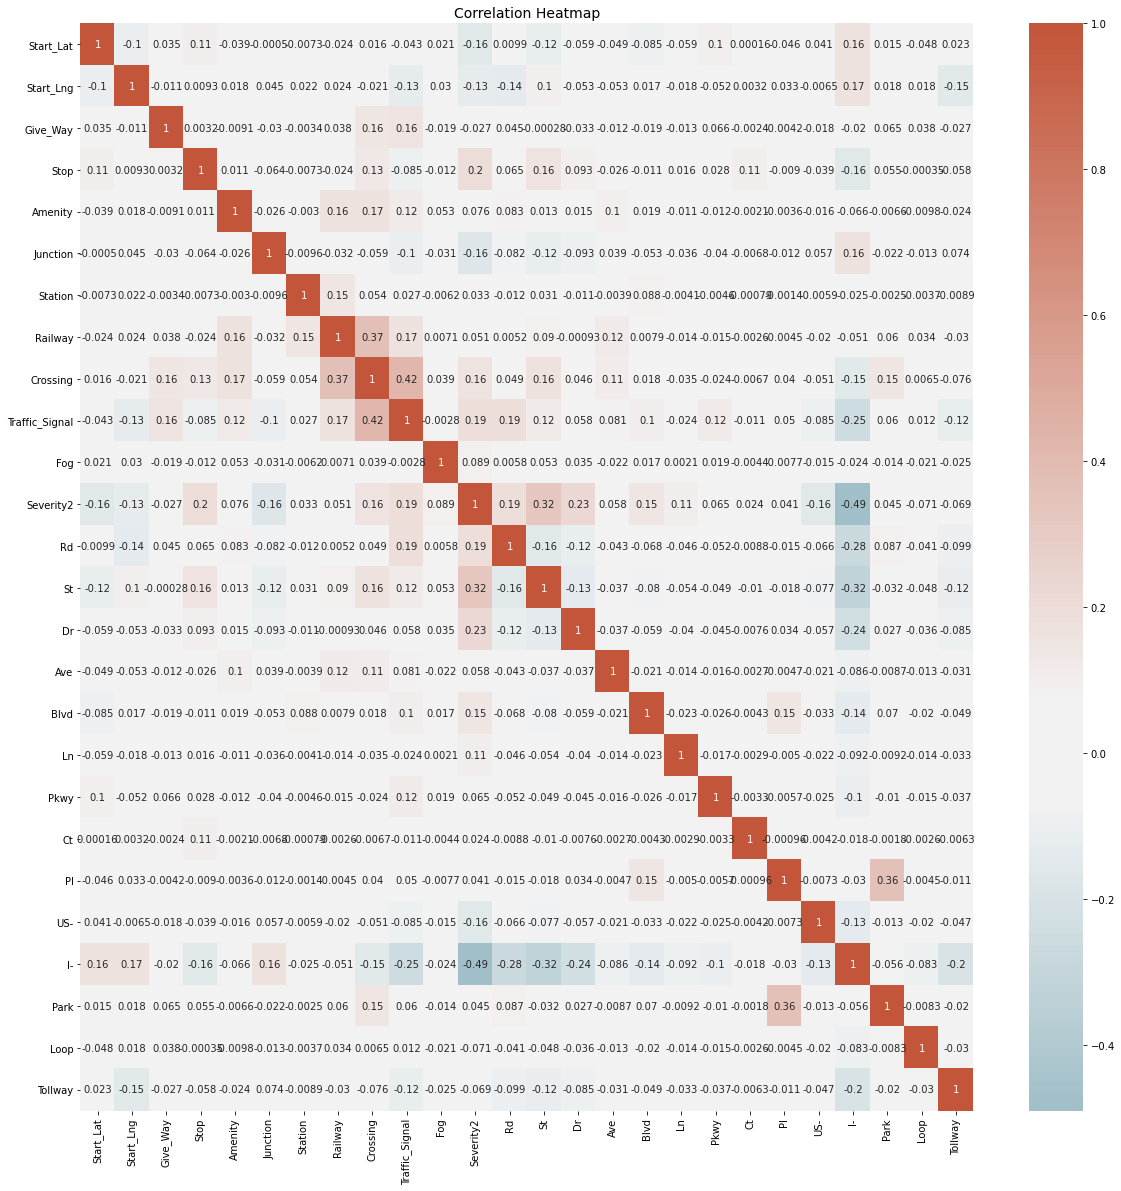

In [28]:
# resample again
df_bl = resample(df, 'Severity2', 900)

# plot correlation
df_bl['Severity2'] = df_bl['Severity2'].astype(int)
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df_bl.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=14)
plt.show()